In [1]:
import torch as T
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import copy
import gym
from gym.wrappers import RescaleAction
import random
from torch.utils.tensorboard import SummaryWriter
from icsl_rl.utils import _read_yaml
from icsl_rl.replaybuffer import PrioritizedReplayBuffer


In [2]:
parameter_patgh = './icsl_rl/Hyperparameter/ddpg.yaml'   # Algorithms can be chosen by themselves
config = _read_yaml(parameter_patgh)
print(config)

{'algorithm': 'DDPG', 'actor_lr': 0.0003, 'critic_lr': 0.001, 'gamma': 0.99, 'tau': 0.005, 'hidden_size': 128, 'target_update_interval': 1, 'buffer_size': 100000, 'batch_size': 128, 'epsilon': 1.0, 'min_epsilon': 0.1, 'epsilon_decay': 0.0001, 'Gaussian_noise': False, 'exploration_noise': 0.1, 'ou_noise_theta': 1.0, 'ou_noise_sigma': 0.1, 'use_epsilon': True, 'is_discrete': False, 'use_noisy_layer': False, 'is_off_policy': True}


In [27]:
import argparse
device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
# In the jupyter book, the argparse library is not easy to use, so use the following form instead
args = argparse.Namespace(algorithm='DQN', device=device, evaluate=False)
args.__dict__ = config
args.device = device                # GPU or CPU
args.seed = 123                     # random seed setting
args.render = False                 # Visualization during training.
args.time_steps = 100000           # total training step
args.episode = 1000000              # total episode
args.save_dir = "./model"           # Where to store the trained model
args.save_rate = 2000               # store rate
args.model_dir = ""                 # Where to store the trained model
args.evaluate_episodes = 10         # Parameters for Model Prediction
args.evaluate = False                # Parameters for Model Prediction
args.evaluate_rate = 1000           # Parameters for Model Prediction
args.is_store_transition = False    # Store expert data
args.env_name = 'Pendulum-v0'          # discrete env
args.hidden_sizes = (128, 128)
args.activation = nn.ReLU
# PER parameters
args.alpha = 0.3
args.beta = 1.0
args.prior_eps = 0.000001    # 1e-6
print(args)

Namespace(Gaussian_noise=False, activation=<class 'torch.nn.modules.activation.ReLU'>, actor_lr=0.0003, algorithm='DDPG', alpha=0.3, batch_size=128, beta=1.0, buffer_size=100000, critic_lr=0.001, device=device(type='cuda', index=0), env_name='Pendulum-v0', episode=1000000, epsilon=1.0, epsilon_decay=0.0001, evaluate=False, evaluate_episodes=10, evaluate_rate=1000, exploration_noise=0.1, gamma=0.99, hidden_size=128, hidden_sizes=(128, 128), is_discrete=False, is_off_policy=True, is_store_transition=False, min_epsilon=0.1, model_dir='', ou_noise_sigma=0.1, ou_noise_theta=1.0, prior_eps=1e-06, render=False, save_dir='./model', save_rate=2000, seed=123, target_update_interval=1, tau=0.005, time_steps=100000, use_epsilon=True, use_noisy_layer=False)


In [28]:
def create_mlp(sizes, activation, output_activation=nn.Identity):
    layers = []
    for j in range(len(sizes)-1):
        act = activation if j < len(sizes)-2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    return nn.Sequential(*layers)

def reset_parameters(Sequential, std=1.0, bias_const=1e-6):
    for layer in Sequential:
        if isinstance(layer, nn.Linear):
            nn.init.orthogonal_(layer.weight, std)
            nn.init.constant_(layer.bias, bias_const)

In [29]:
class Actor(nn.Module): # Deterministic Policy Gradient(DPG), Deep Deterministic Policy Gradient(DDPG), Twin Delayed Deep Deterministic Policy Gradients(TD3)
    def __init__(self, n_states, n_actions, args, max_action=None):
        super(Actor, self).__init__()
        self.device = args.device
        self.max_action = max_action

        self.pi = create_mlp([n_states] + list(args.hidden_sizes) + [n_actions], args.activation, nn.Tanh)

        reset_parameters(self.pi)

        self.to(self.device)

    def forward(self, state):
        u = self.pi(state)
        if self.max_action == None: return u
        return self.max_action*u

In [30]:
class CriticQ(nn.Module): # Action Value Function
    def __init__(self, n_states, n_actions, args):
        super(CriticQ, self).__init__()
        self.device = args.device

        self.Value = create_mlp([n_states + n_actions] + list(args.hidden_sizes) + [1], args.activation)

        reset_parameters(self.Value)

        self.to(self.device)

    def forward(self, state, action):
        cat = T.cat((state, action), dim=-1)
        Q = self.Value(cat)
        return Q


In [31]:
class OUNoise:
    """Ornstein-Uhlenbeck process.
    Taken from Udacity deep-reinforcement-learning github repository:
    https://github.com/udacity/deep-reinforcement-learning/blob/master/
    ddpg-pendulum/ddpg_agent.py
    """

    def __init__(
        self,
        size: int,
        mu: float = 0.0,
        theta: float = 0.15,
        sigma: float = 0.2,
    ):
        """Initialize parameters and noise process."""
        self.state = np.float64(0.0)
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self) -> np.ndarray:
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array(
            [random.random() for _ in range(len(x))]
        )
        self.state = x + dx
        return self.state


In [32]:
class DDPGAgent(object):
    def __init__(self, args):
        self.args = args
        self.actor_path = os.path.join(args.save_dir + '/' + args.algorithm +'/' + args.env_name, 'ddpg_actor.pth')
        self.critic_path = os.path.join(args.save_dir + '/' + args.algorithm +'/' + args.env_name, 'ddpg_critic.pth')

        # Environment setting
        self.env = gym.make(args.env_name)
        self.env = RescaleAction(self.env, -1, 1)
        self.n_states = self.env.observation_space.shape[0]
        self.n_actions = self.env.action_space.shape[0]

        self.max_action = self.env.action_space.high[0]
        self.low_action = self.env.action_space.low[0]

        # OU noise setting
        self.noise = OUNoise(self.n_actions, theta=self.args.ou_noise_theta, sigma=self.args.ou_noise_sigma,)

        # replay buffer
        self.memory = PrioritizedReplayBuffer(self.n_states, self.args, self.args.buffer_size, self.args.alpha)
        self.transition = list()

        # actor-critic network setting
        self.actor_eval = Actor(self.n_states, self.n_actions, self.args)
        self.critic_eval = CriticQ(self.n_states, self.n_actions, self.args)

        # optimizer setting
        self.actor_optimizer = optim.Adam(self.actor_eval.parameters(), lr=self.args.actor_lr)
        self.critic_optimizer = optim.Adam(self.critic_eval.parameters(), lr=self.args.critic_lr)

        # loss function
        self.criterion = nn.MSELoss(reduction='none')

        self.actor_target = copy.deepcopy(self.actor_eval)
        self.actor_target.eval()
        for p in self.actor_target.parameters():
            p.requires_grad = False

        self.critic_target = copy.deepcopy(self.critic_eval)
        self.critic_target.eval()
        for p in self.critic_target.parameters():
            p.requires_grad = False

        # Storage location creation
        if not os.path.exists(self.args.save_dir):
            os.mkdir(self.args.save_dir)

        self.model_path = self.args.save_dir + '/' + args.algorithm
        if not os.path.exists(self.model_path):
            os.mkdir(self.model_path)

        self.model_path = self.model_path + '/' + args.env_name
        if not os.path.exists(self.model_path):
            os.mkdir(self.model_path)

        if os.path.exists(self.model_path + '/ddpg_actor.pth'):
            self.load_models()

        self.total_step = 0

    def choose_action(self, state, epsilon):
        with T.no_grad():
            if epsilon > np.random.random() and not self.args.evaluate:
                choose_action = self.env.action_space.sample()
            else :
                choose_action = self.actor_eval(T.as_tensor(state, dtype=T.float32, device=self.args.device)).detach().cpu().numpy()

            if not self.args.evaluate:
                noise = self.noise.sample()
                choose_action = np.clip(choose_action + noise, self.low_action, self.max_action)
            self.transition = [state, choose_action]
        return choose_action

    def learn(self):
        # TD error
        elementwise_loss, state, weights, indices = self._value_update(self.memory, self.args.batch_size, self.args.beta)

        critic_loss = T.mean(elementwise_loss * weights)

        # update value
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # PER: update priorities
        loss_for_prior = elementwise_loss.detach().cpu().numpy()
        new_priorities = loss_for_prior + self.args.prior_eps
        # print('indices:{}  new_priorities:{}'.format(indices, new_priorities))
        self.memory.update_priorities(indices, new_priorities)

        # critic target network soft update
        if self.total_step % self.args.target_update_interval == 0:
            self._target_soft_update(self.critic_target, self.critic_eval, self.args.tau)

        for p in self.critic_eval.parameters():
            p.requires_grad = False

        # actor network loss function
        actor_loss = self._policy_update(state)

        # update policy
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # actor target network soft update
        if self.total_step % self.args.target_update_interval == 0:
            self._target_soft_update(self.actor_target, self.actor_eval, self.args.tau)

        for p in self.critic_eval.parameters():
            p.requires_grad = True

    def save_models(self):
        print('------ Save model ------')
        _save_model(self.actor_eval, self.actor_path)
        _save_model(self.critic_eval, self.critic_path)

    def load_models(self):
        print('------ load model ------')
        _load_model(self.actor_eval, self.actor_path)
        _load_model(self.critic_eval, self.critic_path)

    # target network soft update
    def _target_soft_update(self, target_net, eval_net , tau=None):
        if tau == None:
            tau = self.args.tau
        with T.no_grad():
            for t_p, l_p in zip(target_net.parameters(), eval_net.parameters()):
                t_p.data.copy_(tau * l_p.data + (1 - tau) * t_p.data)

    def _value_update(self, buffer, batch_size, beta):
        with T.no_grad():
            # Select data from ReplayBuffer with batch_size size
            samples = buffer.sample_batch(batch_size, beta)

            state = T.as_tensor(samples['state'], dtype=T.float32, device=self.args.device)
            next_state = T.as_tensor(samples['next_state'], dtype=T.float32, device=self.args.device)

            action = T.as_tensor(samples['action'], dtype=T.float32, device=self.args.device).reshape(-1, 1)
            reward = T.as_tensor(samples['reward'], dtype=T.float32, device=self.args.device).reshape(-1,1)
            mask = T.as_tensor(samples['mask'], dtype=T.float32, device=self.args.device).reshape(-1,1)

            weights = T.as_tensor(samples["weights"], dtype=T.float32, device=self.args.device).reshape(-1, 1)
            indices = samples["indices"]

            next_action = self.actor_target(next_state)
            next_value = self.critic_target(next_state, next_action)
            # Here we calculate action value Q(s,a) = R + yV(s')
            target_values = reward + next_value * mask

        eval_values = self.critic_eval(state, action)
        # TD error
        elementwise_loss = self.criterion(eval_values, target_values)

        return elementwise_loss, state, weights, indices

    def _policy_update(self, state):
        actor_loss = -self.critic_eval(state, self.actor_eval(state)).mean()
        return actor_loss

# model save functions
def _save_model(net, dirpath):
    T.save(net.state_dict(), dirpath)

# model load functions
def _load_model(net, dirpath):
    net.load_state_dict(T.load(dirpath))


In [33]:
import numpy as np
from icsl_rl.utils import _make_gif, _evaluate_agent, _store_expert_data
import torch as T

class Runner:
    def __init__(self, agent, args, env, writer):
        self.args = args
        self.epsilon = args.epsilon
        self.episode_limit = env.spec.max_episode_steps
        self.env = env
        self.agent = agent
        self.writer = writer

    def run(self):
        best_score = self.env.reward_range[0]

        scores = []
        store_scores = []
        eval_rewards = []

        avg_score = 0
        n_updates = 0

        for i in range(self.args.episode):
            state = self.env.reset()
            cur_episode_steps = 0
            score = 0
            done = False
            while (not done):
                if self.args.render:
                    self.env.render()

                cur_episode_steps += 1
                self.agent.total_step += 1
                action = self.agent.choose_action(state, self.epsilon)
                next_state, reward, done, _ = self.env.step(action)

                real_done = False if cur_episode_steps >= self.episode_limit else done
                mask = 0.0 if real_done else self.args.gamma
                self.agent.transition += [reward, next_state, mask]
                self.agent.memory.store(*self.agent.transition)
                state = next_state
                score += reward

                fraction = min(self.agent.total_step / self.args.time_steps, 1.0)
                self.args.beta = self.args.beta + fraction * (1.0 - self.args.beta)

                if self.agent.memory.ready(self.args.batch_size):
                    self.agent.learn()
                    n_updates += 1
                    self.epsilon = max(0.1, self.epsilon - self.args.epsilon_decay)

                if self.agent.total_step % self.args.evaluate_rate == 0 and self.agent.memory.ready(self.args.batch_size):
                    running_reward = np.mean(scores[-10:])
                    eval_reward = _evaluate_agent(self.env, self.agent, self.args, n_starts=self.args.evaluate_episodes)
                    eval_rewards.append(eval_reward)
                    self.writer.add_scalar('Reward/Train', running_reward, self.agent.total_step)
                    self.writer.add_scalar('Reward/Test', eval_reward, self.agent.total_step)
                    print('| Episode : {} | Score : {} | Predict Score : {} | Avg score : {} |'.format(i, round(score, 2), round(eval_reward, 2), round(avg_score, 2)))
                    scores = []


            scores.append(score)
            store_scores.append(score)
            avg_score = np.mean(store_scores[-10:])

            np.savetxt(self.args.save_dir + '/' + self.args.algorithm + '/' + self.args.env_name + '/episode_return.txt', store_scores, delimiter=",")
            np.savetxt(self.args.save_dir + '/' + self.args.algorithm + '/' + self.args.env_name + '/step_return.txt', eval_rewards, delimiter=",")

            if avg_score > best_score:
                best_score = avg_score
                self.agent.save_models()

            if self.agent.total_step >= self.args.time_steps:
                print('Reach the maximum number of training steps ！')
                break

            if avg_score >= -140:
                print('Stop Training')
                break

            print('Episode : {} | Score : {} | Avg score : {} | Time_Step : {} |  update number : {} |'.format(i, round(score, 2), round(avg_score, 2), self.agent.total_step, n_updates))

        self.env.close()

    def evaluate(self):
        returns = _evaluate_agent(self.env, self.agent, self.args, n_starts=1)

    def gif(self, policy, env, maxsteps=1000):
        _make_gif(policy, env, self.args, maxsteps)

In [34]:
def _random_seed(seed):      # random seed setting
    if T.backends.cudnn.enabled:
        T.backends.cudnn.benchmark = False
        T.backends.cudnn.deterministic = True

    T.manual_seed(seed)
    T.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    print('Using GPU : ', T.cuda.is_available() , ' |  Seed : ', seed)

In [35]:
_random_seed(args.seed)

Using GPU :  True  |  Seed :  123


In [36]:
writer = SummaryWriter('./logs/' + args.algorithm)           # Tensorboard

In [37]:
agent = DDPGAgent(args)            # agent setting
runner = Runner(agent, args, agent.env, writer)

In [38]:
runner.run()                  # Training

------ Save model ------
Episode : 0 | Score : -1078.0 | Avg score : -1078.0 | Time_Step : 200 |  update number : 73 |
------ Save model ------
Episode : 1 | Score : -887.25 | Avg score : -982.62 | Time_Step : 400 |  update number : 273 |
------ Save model ------
Episode : 2 | Score : -951.32 | Avg score : -972.19 | Time_Step : 600 |  update number : 473 |
Episode : 3 | Score : -1013.7 | Avg score : -982.57 | Time_Step : 800 |  update number : 673 |
| Episode : 4 | Score : -1451.67 | Predict Score : -1615.6 | Avg score : -982.57 |
Episode : 4 | Score : -1451.67 | Avg score : -1076.39 | Time_Step : 1000 |  update number : 873 |
Episode : 5 | Score : -887.05 | Avg score : -1044.83 | Time_Step : 1200 |  update number : 1073 |
Episode : 6 | Score : -1446.54 | Avg score : -1102.22 | Time_Step : 1400 |  update number : 1273 |
Episode : 7 | Score : -1782.17 | Avg score : -1187.21 | Time_Step : 1600 |  update number : 1473 |
Episode : 8 | Score : -1208.44 | Avg score : -1189.57 | Time_Step : 1

In [39]:
ddpg_total_path = './model/DDPG/Pendulum-v0/episode_return.txt'
ddpg_step_path = './model/DDPG/Pendulum-v0/step_return.txt'
ddpg_total =  np.loadtxt(ddpg_total_path, delimiter=',')
ddpg_step =  np.loadtxt(ddpg_step_path, delimiter=',')

In [40]:
def var_name(var,all_var=locals()):
    return [var_name for var_name in all_var if all_var[var_name] is var][0]

In [41]:
import matplotlib.pyplot as plt
import os
import numpy as np
def _step_plot(scores):
    plt.figure(figsize=(10,5))
    plt.title("Step Reward")
    plt.grid(True)

    name = var_name(scores).replace('_step', '')

    plt.xlabel("step * 1000")
    plt.ylabel("Average Reward")
    plt.plot(scores, "r-", linewidth=1.5, label= name + "_reward")
    plt.legend(loc="best", shadow=True)
    plt.show()

def _avg_plot(scores):
    plt.figure(figsize=(10,5))
    plt.title("Reward")
    plt.grid(True)

    name = var_name(scores).replace('_total', '')

    z = [c+1 for c in range(len(scores))]
    running_avg = np.zeros(len(scores))
    for e in range(len(running_avg)):
        running_avg[e] = np.mean(scores[max(0, e-10):(e+1)])

    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.plot(scores, "r-", linewidth=1.5, label= name + "_reward")
    plt.plot(z, running_avg, "b-", linewidth=1.5, label= name + "_avg_reward")
    plt.legend(loc="best", shadow=True)
    plt.show()

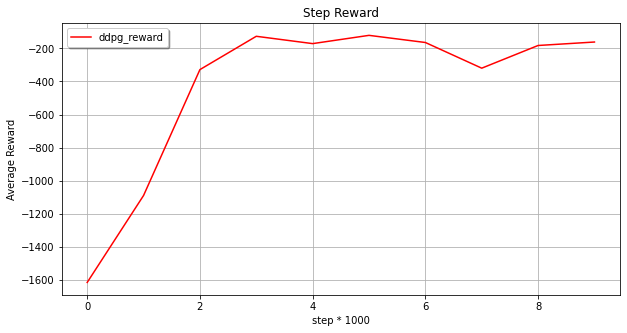

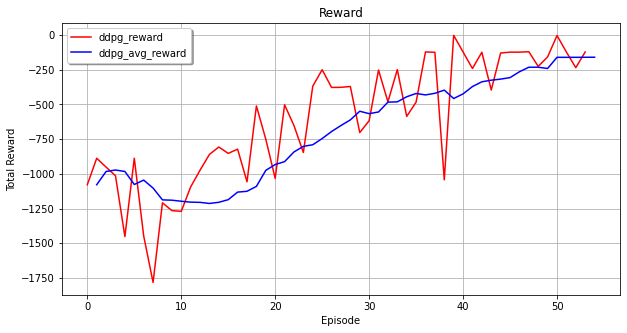

In [42]:
_step_plot(ddpg_step)
_avg_plot(ddpg_total)